In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as pn
from plotnine import (
    aes,
    element_text,
    facet_grid,
    geom_point,
    ggplot,
    scale_x_discrete,
    stat_smooth,
    theme,
)

pn.options.figure_size = (10, 15)
plt.style.use("ggplot")

# ICPW Thematic report 2023

## Part C: Lowess-smoothed, standardised data series

[here](https://nbviewer.org/github/JamesSample/icpw/blob/master/toc_report_feb_2019_part4_wge_plots.ipynb).

In [2]:
# Parameters of interest for analysis
par_list = [
    "SO4_µeq/l",
    "NO3-N_µeq/l",
    # "NH4-N_µeq/l",
    "Cl_µeq/l",
    "Ca_µeq/l",
    "Mg_µeq/l",
    "CaMg_µeq/l",
    "H_µeq/l",
    "SAA_µeq/l",
    "ANC_µeq/l",
    "OrgAnions_µeq/l",
    "HCO3_µeq/l",
    "TOC_mg C/l",
]

# Periods to consider
st_yr, end_yr = 1990, 2020

In [3]:
# Station propertiess
xl_path = r"../../../all_icpw_sites_mar_2023.xlsx"
stn_df = pd.read_excel(xl_path, sheet_name="all_icpw_stns")

# Median annual chemistry
csv_path = r"./data/thematic_report_2023_working_data.csv"
wc_df = pd.read_csv(csv_path, encoding="utf-8")
wc_df["sample_date"] = pd.to_datetime(wc_df["sample_date"], format="%Y-%m-%d")
wc_df["year"] = wc_df["sample_date"].dt.year
wc_df = wc_df.groupby(["station_id", "year"]).median().reset_index()
wc_df = wc_df[["station_id", "year"] + par_list]

# Selection criteria
csv_path = r"./data/selection_criteria_by_station-par-period.csv"
inc_df = pd.read_csv(csv_path, encoding="utf-8")
inc_df = inc_df[["station_id", "period"] + par_list]
# del inc_df["NH4-N_µeq/l"] # Don't care about NH4 for site selection - see above
inc_df.set_index(["station_id", "period"], inplace=True)
inc_df[inc_df == 0] = np.nan
inc_df.dropna(how="any", inplace=True)
inc_df.reset_index(inplace=True)

In [4]:
# Filter sites and time period
stn_list = (
    inc_df.groupby(["station_id"])[["period"]]
    .count()
    .query("period == 4")
    .index.tolist()
)

print(
    "All periods:",
    len(stn_list),
    "sites.",
)

wc_df = wc_df.query("(station_id in @stn_list) and (@st_yr <= year <= @end_yr)")

All periods: 403 sites.


In [5]:
# Loop over sites
df_list = []
for idx, row in stn_df.iterrows():
    # Get station metadata
    stn_id = row["station_id"]
    region = row["region"]

    # Read series
    df = wc_df.query("station_id == @stn_id").copy()

    if len(df) > 0:
        # Delete unwanted cols and tidy
        del df["station_id"]
        df.set_index("year", inplace=True)
        df.sort_index(inplace=True)

        # Get first value in series
        for col in df.columns:
            # Values equal to exactly zero must be wrong
            # Convert to NaN
            df[col][df[col] == 0] = np.nan
            vals = df[col].dropna().values

            # If at least one valid value in series, get the first
            if len(vals) > 0:
                first = vals[0]
            else:
                first = np.nan

            # Apply scaling
            df[col] = (df[col] - first) / df[col].std()

        # Build results df
        df["region"] = region
        df["station_id"] = stn_id
        df.reset_index(inplace=True)
        df_list.append(df)

# Combine and tidy
df = pd.concat(df_list, axis=0)
df["year"] = df["year"].astype(int)
df.reset_index(inplace=True, drop=True)
df = df.melt(id_vars=["year", "region", "station_id"])
df.dropna(how="any", inplace=True)

# Remove units
df[["variable", "unit"]] = df["variable"].str.split("_", 1, expand=True)
del df["unit"]

df.head()

,year,region,station_id,variable,value
0,1990,Ont,38115,SO4,0.000000
1,1991,Ont,38115,SO4,-0.403360
2,1992,Ont,38115,SO4,-0.569390
3,1993,Ont,38115,SO4,-0.723196
4,1994,Ont,38115,SO4,-1.254898


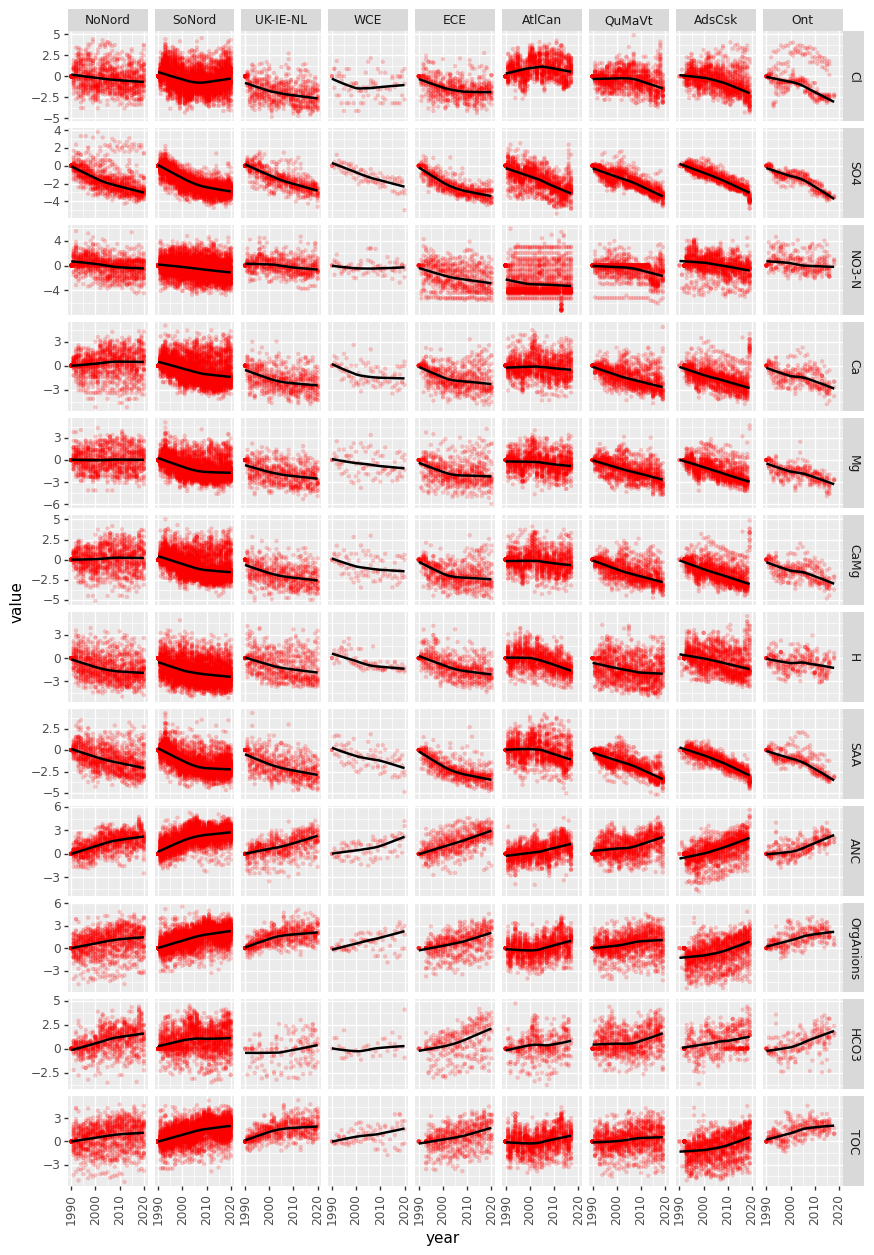

<ggplot: (8735473860350)>

In [6]:
# Specify order for facets
df["region"] = pd.Categorical(
    df["region"],
    ordered=True,
    categories=[
        "NoNord",
        "SoNord",
        "UK-IE-NL",
        "WCE",
        "ECE",
        "AtlCan",
        "QuMaVt",
        "AdsCsk",
        "Ont",
    ],
)
df["variable"] = pd.Categorical(
    df["variable"],
    ordered=True,
    categories=[
        "Cl",
        "SO4",
        "NO3-N",
        "Ca",
        "Mg",
        "CaMg",
        "H",
        "SAA",
        "ANC",
        "OrgAnions",
        "HCO3",
        "TOC",
    ],
)

# Plot
p = (
    ggplot(df, aes("year", "value"))
    + geom_point(alpha=0.2, stroke=0.1, color="red")
    + stat_smooth(method="lowess", se=False)
    + facet_grid("variable~region", scales="free_y", shrink=True)
    + theme(axis_text_x=element_text(rotation=90))
)
p

In [7]:
out_png = r"./results/raw_wq_trends_smoothed.png"
p.save(out_png, width=8, height=12, units="in", dpi=300)

/opt/conda/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 8 x 12 in image.
/opt/conda/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ./results/raw_wq_trends_smoothed.png
